# **PLEASE CHANGE THE FILE PATH ACCORDING TO YOUR FILE SAVED LOCATION IN THE READ CSV SECTION**

### **LIBRARIES**

In [38]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score

### **LOAD DATASET**

In [2]:
data = pd.read_csv('/content/drive/MyDrive/EV Charging Demand Prediction Model/Electric_Vehicle_Population_By_County.csv')

In [3]:
data.head(10)

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19
5,May 31 2018,Maui,HI,Passenger,1,0,1,59,60,1.67
6,November 30 2017,Northampton,PA,Passenger,0,1,1,66,67,1.49
7,March 31 2018,Nassau,NY,Passenger,1,0,1,37,38,2.63
8,March 31 2020,DeKalb,IN,Passenger,1,0,1,1,2,50.00
9,January 31 2019,Columbia,WA,Truck,0,0,0,"1,529","1,529",0.00


### **EXPLORATION**

In [4]:
data.shape

(20819, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [7]:
data.describe()

,Percent Electric Vehicles
count,20819.000000
mean,4.139216
std,11.055350
min,0.000000
25%,0.390000
50%,1.220000
75%,2.995000
max,100.000000


In [8]:
data.isnull().sum()

,0
Date,0
County,86
State,86
Vehicle Primary Use,0
Battery Electric Vehicles (BEVs),0
Plug-In Hybrid Electric Vehicles (PHEVs),0
Electric Vehicle (EV) Total,0
Non-Electric Vehicle Total,0
Total Vehicles,0
Percent Electric Vehicles,0


In [9]:
Q1 = data['Percent Electric Vehicles'].quantile(0.25)
Q3 = data['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
print('Upper Bound:', upper_bound)
print('Lower Bound:', lower_bound)

outliers = data[(data['Percent Electric Vehicles'] < lower_bound) | (data['Percent Electric Vehicles'] > upper_bound)]
print('Number of outliers:', outliers.shape[0])

Upper Bound: 6.9025
Lower Bound: -3.5174999999999996
Number of outliers: 2476


### **DATA PREPROCESSING**

In [10]:
data['Date'] = pd.to_datetime(data['Date'], errors = 'coerce')

data = data[data['Date'].notnull()]
data = data[data['Electric Vehicle (EV) Total'].notnull()]

data['County'] = data['County'].fillna('Unknown')
data['State'] = data['State'].fillna('Unknown')

print('Missing After Fill:')
print(data[['County', 'State']].isnull().sum())

Missing After Fill:
County    0
State     0
dtype: int64


In [11]:
data.head(10)

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19
5,2018-05-31,Maui,HI,Passenger,1,0,1,59,60,1.67
6,2017-11-30,Northampton,PA,Passenger,0,1,1,66,67,1.49
7,2018-03-31,Nassau,NY,Passenger,1,0,1,37,38,2.63
8,2020-03-31,DeKalb,IN,Passenger,1,0,1,1,2,50.00
9,2019-01-31,Columbia,WA,Truck,0,0,0,"1,529","1,529",0.00


In [12]:
data['Percent Electric Vehicles'] = np.where(data['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                             np.where(data['Percent Electric Vehicles'] < lower_bound, lower_bound,
                                             data['Percent Electric Vehicles']))

In [13]:
outliers = data[(data['Percent Electric Vehicles'] < lower_bound) | (data['Percent Electric Vehicles'] > upper_bound)]
print('Number of outliers:', outliers.shape[0])

Number of outliers: 0


In [14]:
columns_to_convert = ['Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)', 'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total', 'Total Vehicles', 'Percent Electric Vehicles']

for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

data[columns_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,31.623093,132.845312,134.463767,2.122378
std,102.004224,92.309729,115.742017,174.033916,174.448753,2.277542
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,999.000000,999.000000,998.000000,6.902500


In [15]:
top_counties = data.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending = False).head(3)
bottom_counties = data.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print('Top 3 Counties with Highest EV Population:')
print(top_counties)

print('\nBottom 3 Counties with Lowest EV Population:')
print(bottom_counties)

Top 3 Counties with Highest EV Population:
County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties with Lowest EV Population:
County
Brown         1.0
Union         1.0
Hood River    1.0
Name: Electric Vehicle (EV) Total, dtype: float64


### **DATA VISUALIZATION**

In [16]:
total_bev = data['Battery Electric Vehicles (BEVs)'].sum()
total_phev = data['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
total_ev = data['Electric Vehicle (EV) Total'].sum()
total_non_ev = data['Non-Electric Vehicle Total'].sum()
all_total = data['Total Vehicles'].sum()

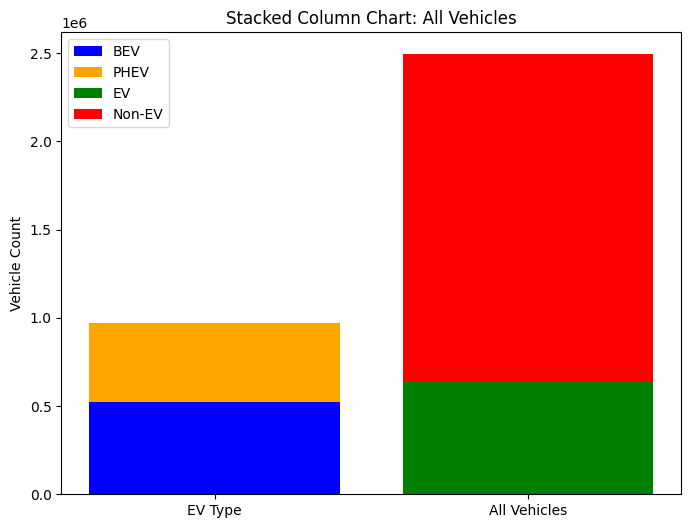

In [17]:
figure, ax = plt.subplots(figsize = (8, 6))

ax.bar('EV Type', total_bev, label = 'BEV', color = 'blue')
ax.bar('EV Type', total_phev, bottom = total_bev, label = 'PHEV', color = 'orange')
ax.bar('All Vehicles', total_ev, label = 'EV', color = 'green')
ax.bar('All Vehicles', total_non_ev, bottom = total_ev, label = 'Non-EV', color = 'red')

ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: All Vehicles')
ax.legend()

plt.show()

/tmp/ipython-input-18-1428242061.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_counties_state, y='County_State', x='Electric Vehicle (EV) Total', palette='viridis') # Use Electric Vehicle (EV) Total for plotting


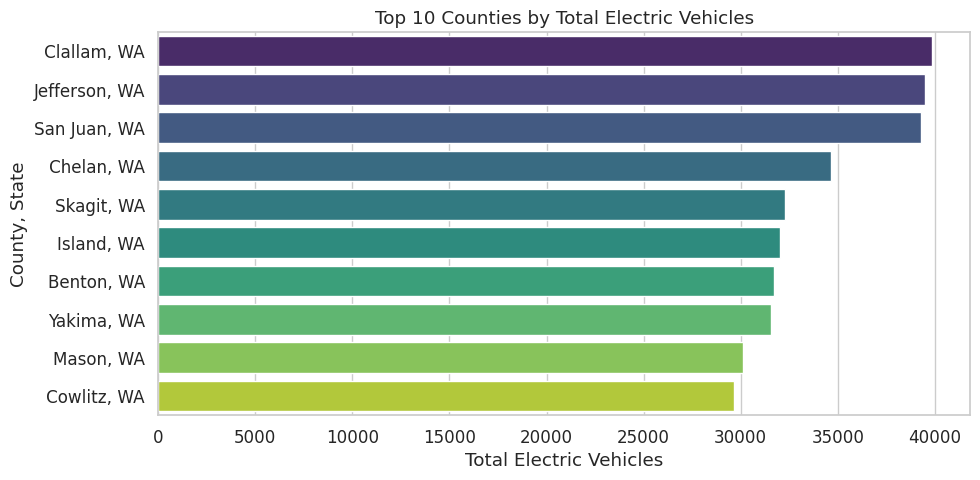

In [18]:
sns.set(style="whitegrid", font_scale=1.1)

top_10_counties_state = data.groupby(['County', 'State'])['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(10).reset_index()
top_10_counties_state['County_State'] = top_10_counties_state['County'].astype(str) + ', ' + top_10_counties_state['State']

plt.figure(figsize=(10, 5))

sns.barplot(data=top_10_counties_state, y='County_State', x='Electric Vehicle (EV) Total', palette='viridis') # Use Electric Vehicle (EV) Total for plotting
plt.title('Top 10 Counties by Total Electric Vehicles')
plt.xlabel('Total Electric Vehicles')
plt.ylabel('County, State')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

/tmp/ipython-input-19-2076899702.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ratios['BEV_to_PHEV_Ratio'], y=top_ratios.index, palette='coolwarm')


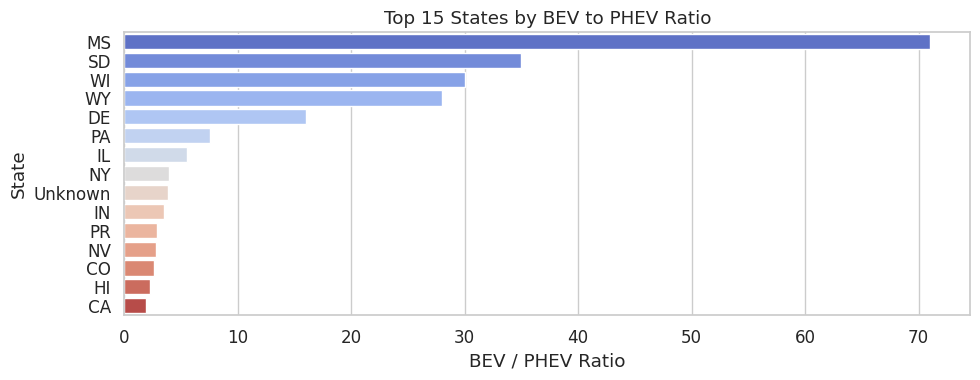

In [19]:
bev_phev = data.groupby('State')[['Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)']].sum()
bev_phev['BEV_to_PHEV_Ratio'] = bev_phev['Battery Electric Vehicles (BEVs)'] / (bev_phev['Plug-In Hybrid Electric Vehicles (PHEVs)'] + 1)

top_ratios = bev_phev.sort_values('BEV_to_PHEV_Ratio', ascending=False).head(15)

plt.figure(figsize=(10,4))
sns.barplot(x=top_ratios['BEV_to_PHEV_Ratio'], y=top_ratios.index, palette='coolwarm')
plt.title('Top 15 States by BEV to PHEV Ratio')
plt.xlabel('BEV / PHEV Ratio')
plt.ylabel('State')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

### **FEATURE ENGINEERING**

In [20]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Numeric_Date'] = data['Year'] * 12 + data['Month']

In [21]:
le = LabelEncoder()
data['County_Encoded'] = le.fit_transform(data['County'])

In [22]:
data = data.sort_values(['County', 'Date'])

In [23]:
data['Months_Since_Start'] = data.groupby('County').cumcount()

for lag in [1, 2, 3]:
  data[f'total_ev_lag_{lag}'] = data.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

data[f'total_ev_rolling_mean_{lag}'] = data.groupby('County')['Electric Vehicle (EV) Total'] \
                                            .transform(lambda x: x.shift(1).rolling(3).mean())
data['ev_percent_change_1'] = data.groupby('County')['Electric Vehicle (EV) Total'] \
                                  .pct_change(periods = 1, fill_method = None)
data['ev_percent_change_3'] = data.groupby('County')['Electric Vehicle (EV) Total'] \
                                  .pct_change(periods = 3, fill_method = None)

data['ev_percent_change_1'] = data['ev_percent_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
data['ev_percent_change_3'] = data['ev_percent_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [24]:
data['Cummulative_EV_Sum'] = data.groupby('County')['Electric Vehicle (EV) Total'].cumsum()
data['EV_Growth_Slope'] = data.groupby('County')['Cummulative_EV_Sum'].transform(lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan))

In [25]:
data = data.dropna().reset_index(drop = True)

In [26]:
data.to_csv('/content/drive/MyDrive/EV Charging Demand Prediction Model/preprocessed_ev_data.csv', index = False)
data.head(10)

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,County_Encoded,Months_Since_Start,total_ev_lag_1,total_ev_lag_2,total_ev_lag_3,total_ev_rolling_mean_3,ev_percent_change_1,ev_percent_change_3,Cummulative_EV_Sum,EV_Growth_Slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000
5,2018-10-31,Ada,ID,Passenger,0.0,2.0,2.0,326.0,328.0,0.61,...,0,10,2.0,2.0,2.0,2.0,0.0,0.0,20.0,2.000000
6,2018-11-30,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,11,2.0,2.0,2.0,2.0,0.0,0.0,22.0,2.000000
7,2018-12-31,Ada,ID,Passenger,0.0,2.0,2.0,324.0,326.0,0.61,...,0,12,2.0,2.0,2.0,2.0,0.0,0.0,24.0,2.000000
8,2019-01-31,Ada,ID,Passenger,0.0,2.0,2.0,322.0,324.0,0.62,...,0,13,2.0,2.0,2.0,2.0,0.0,0.0,26.0,2.000000
9,2019-02-28,Ada,ID,Passenger,0.0,2.0,2.0,320.0,322.0,0.62,...,0,14,2.0,2.0,2.0,2.0,0.0,0.0,28.0,2.000000


In [27]:
features = ['Months_Since_Start', 'County_Encoded', 'total_ev_lag_1', 'total_ev_lag_2', 'total_ev_lag_3', 'total_ev_rolling_mean_3', 'ev_percent_change_1', 'ev_percent_change_3', 'EV_Growth_Slope']
target = 'Electric Vehicle (EV) Total'

X = data[features]
y = data[target]

In [28]:
X.head()

,Months_Since_Start,County_Encoded,total_ev_lag_1,total_ev_lag_2,total_ev_lag_3,total_ev_rolling_mean_3,ev_percent_change_1,ev_percent_change_3,EV_Growth_Slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [30]:
X.shape

(12573, 9)

In [31]:
X_train, X_test, y_train, y_test = tts(X, y, shuffle = False, test_size = 0.1)

In [32]:
y_test.head()

,Electric Vehicle (EV) Total
11315,1.0
11316,1.0
11317,1.0
11318,1.0
11319,1.0


### **MODEL SELECTION**

In [34]:
parameter_distribution = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

rfr = RandomForestRegressor(random_state = 42)

rs = RandomizedSearchCV(estimator = rfr, param_distributions = parameter_distribution, n_iter = 30, cv = 3, verbose = 1, random_state = 42, n_jobs = -1, scoring='r2')

rs.fit(X_train, y_train)

model = rs.best_estimator_
print('Best Parameters:', rs.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [35]:
y_pred = model.predict(X_test)

### **EVALUATION METRICS**

In [37]:
comparison_data = pd.DataFrame({'Actual EV Count': y_test.values, 'Predicted EV Count': y_pred})

comparison_data['Predicted EV Count'] = comparison_data['Predicted EV Count'].round(2)
comparison_data.reset_index(drop = True, inplace = True)

comparison_data.head(10)

,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [40]:
def evaluate(y_true, y_pred):
  ma_error = mae(y_true, y_pred)
  ms_error = mse(y_true, y_pred)
  rms_error = np.sqrt(ms_error)
  r2 = r2_score(y_true, y_pred)
  print(f'Mean Absolute Error: {ma_error:.2f}')
  print(f'Root Mean Square Error: {rms_error:.2f}')
  print(f'R2 Score: {r2:.2f}')

evaluate(y_test, y_pred)

Mean Absolute Error: 0.01
Root Mean Square Error: 0.06
R2 Score: 1.00


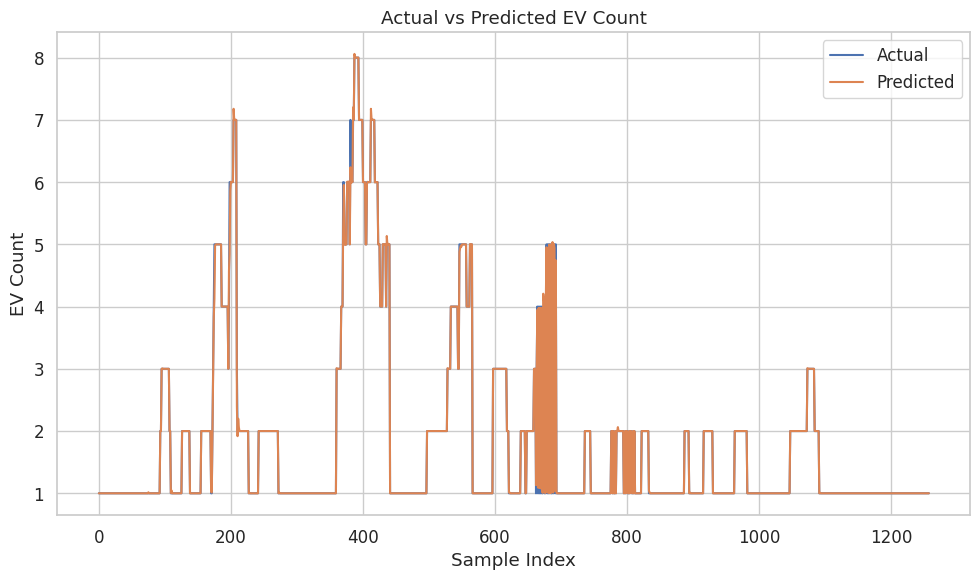

In [41]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

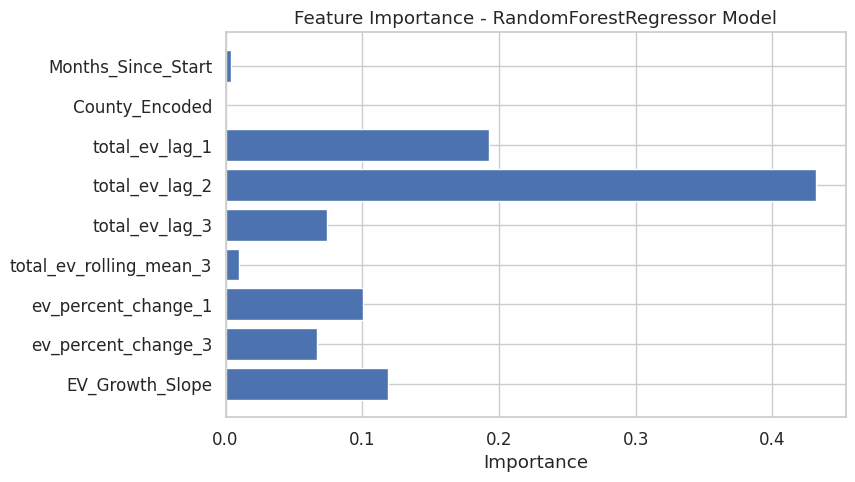

In [42]:
importances = model.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.title('Feature Importance - RandomForestRegressor Model')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

### **NEXT 3 YEARS FORECASTING USING REGRESSION MODEL**

#### **FOR ONE SPECIFIC COUNTY**

In [46]:
featuresX = ['County', 'County_Encoded']
countyX = data[featuresX]

print('List Of Unique Counties:')
print(data['County'].dropna().unique())

List Of Unique Counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Atlantic' 'Autauga'
 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Berkshire'
 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard' 'Broward' 'Bryan' 'Bucks'
 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon' 'Carroll' 'Carson City'
 'Cascade' 'Champaign' 'Charles' 'Charleston' 'Charlottesville'
 'Chesapeake' 'Clackamas' 'Clay' 'Clinton' 'Cobb' 'Cochise' 'Collier'
 'Collin' 'Columbia' 'Contra Costa' 'Cook' 'Coryell' 'Cumberland'
 'Currituck' 'Dakota' 'Dale' 'Dallas' 'Dane' 'Danville' 'DeKalb' 'Denton'
 'Denver' 'Deschutes' 'District of Columbia' 'Dorchester' 'Douglas'
 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado' 'El Paso' 'Escambia'
 'Essex' 'Fairbanks North Star' 'Fairfax' 'Flathead' 'Fort Bend'
 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston' 'Garfield' 'Geary'
 'Goochland' 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton' 'Hamps

In [47]:
print('Total Unique Counties:', data['County'].nunique())

Total Unique Counties: 269


County 'Kings' encoded as 130.


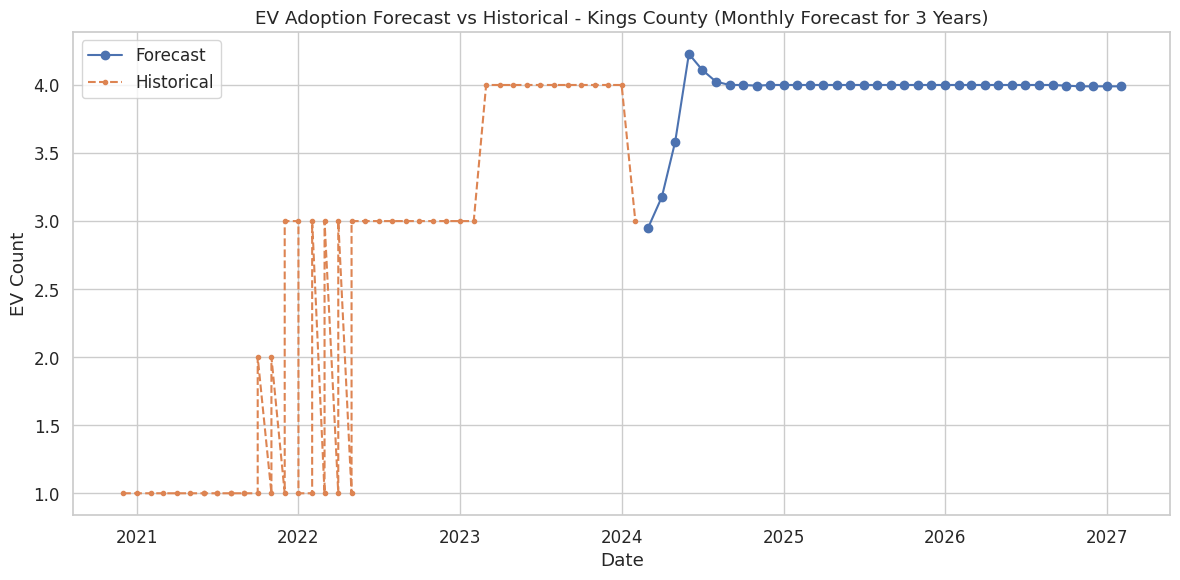

In [52]:
county = 'Kings'

try:
  county_code = le.transform([county])[0]
  print(f"County '{county}' encoded as {county_code}.")
except ValueError:
  print(f"Error: '{county}' not found in LabelEncoder.")
  exit()

county_data = data[data['County_Encoded'] == county_code].sort_values("Numeric_Date")
if county_data.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()

historical_ev = list(county_data['Electric Vehicle (EV) Total'].values[-6:])
Cummulative_EV_Sum = list(np.cumsum(historical_ev))
slope_history = []
Months_Since_Start = county_data['Months_Since_Start'].max()

historical = county_data[['Year', 'Month', 'Numeric_Date', 'Electric Vehicle (EV) Total', 'Months_Since_Start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['Year', 'Month']].assign(day=1))

latest_row = county_data.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['Year'] * 100 + latest_row['Month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    Months_Since_Start += 1

    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

    recent_cumulative = Cummulative_EV_Sum[-6:]
    EV_Growth_Slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    new_row = {
        'Months_Since_Start': Months_Since_Start,
        'County_Encoded': county_code,
        'total_ev_lag_1': lag1,
        'total_ev_lag_2': lag2,
        'total_ev_lag_3': lag3,
        'total_ev_rolling_mean_3': roll_mean,
        'ev_percent_change_1': pct_change_1,
        'ev_percent_change_3': pct_change_3,
        'EV_Growth_Slope': EV_Growth_Slope
    }

    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    Cummulative_EV_Sum.append(Cummulative_EV_Sum[-1] + pred)
    if len(Cummulative_EV_Sum) > 6:
        Cummulative_EV_Sum.pop(0)

    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'Months_Since_Start': Months_Since_Start,
        'Source': 'Forecast'
    })

    latest_row['Year'], latest_row['Month'] = y, m

forecast_data = pd.DataFrame(future_rows)

historical['Date'] = pd.to_datetime(historical[['Year', 'Month']].assign(day=1))
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'Months_Since_Start', 'Source']]
combined = pd.concat([historical, forecast_data], ignore_index=True)

plt.figure(figsize=(12, 6))

for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'], label=source,
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"EV Adoption Forecast vs Historical - {county} County (Monthly Forecast for 3 Years)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

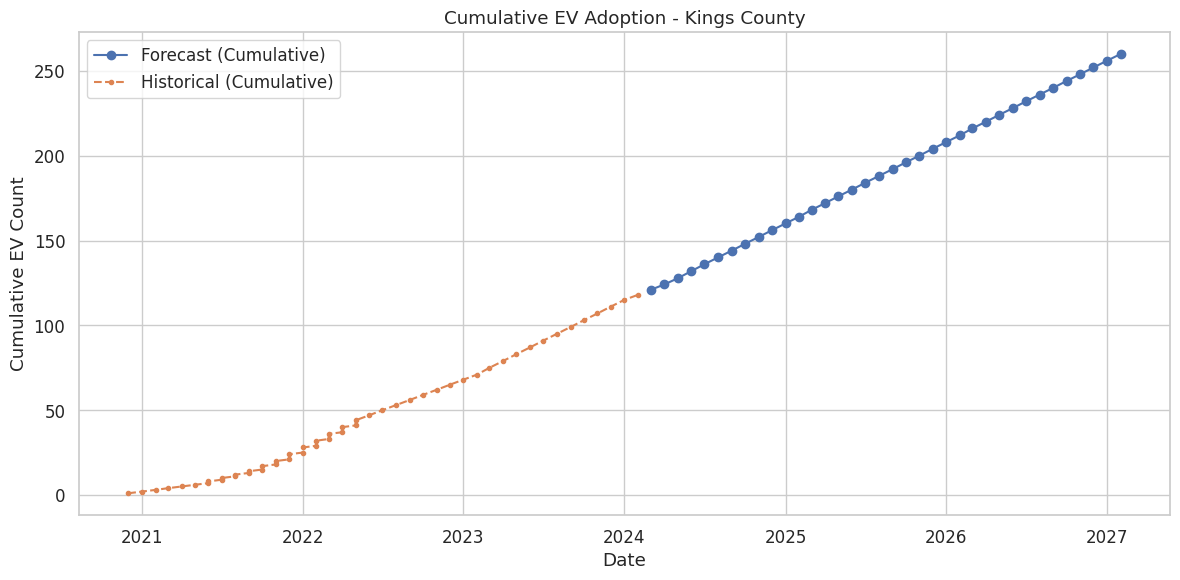

In [53]:
combined = combined.sort_values("Date")

combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

plt.figure(figsize=(12, 6))

for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### **FOR TOP 5 COUNTIES**

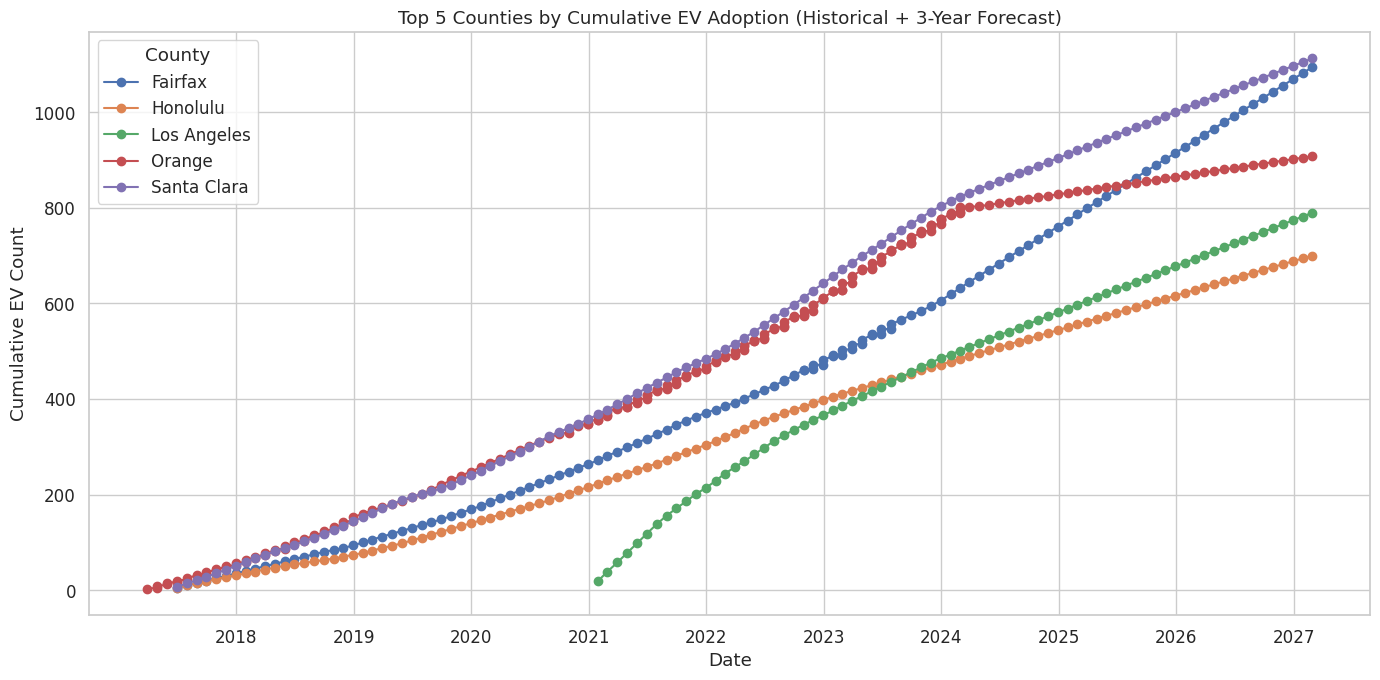

In [55]:
forecast_horizon = 36

all_combined = []
unique_counties = data['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_data = data[data['County_Encoded'] == county_code].sort_values("Numeric_Date")
    if county_data.empty or county_data.shape[0] < 6:
        continue

    Months_Since_Start = county_data['Months_Since_Start'].max()

    historical = county_data[['Date', 'Electric Vehicle (EV) Total', 'Months_Since_Start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_data['Electric Vehicle (EV) Total'].values[-6:])
    Cummulative_EV_Sum = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        Months_Since_Start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = Cummulative_EV_Sum[-6:]
        EV_Growth_Slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        slope_history.append(EV_Growth_Slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'Months_Since_Start': Months_Since_Start,
            'County_Encoded': county_code,
            'total_ev_lag_1': lag1,
            'total_ev_lag_2': lag2,
            'total_ev_lag_3': lag3,
            'total_ev_rolling_mean_3': roll_mean,
            'ev_percent_change_1': pct_change_1,
            'ev_percent_change_3': pct_change_3,
            'EV_Growth_Slope': EV_Growth_Slope
        }

        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        Cummulative_EV_Sum.append(Cummulative_EV_Sum[-1] + pred)
        if len(Cummulative_EV_Sum) > 6:
            Cummulative_EV_Sum.pop(0)

        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'Months_Since_Start': Months_Since_Start,
            'County': county,
            'Source': 'Forecast'
        })

    forecast_data = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_data], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

full_data = pd.concat(all_combined)

final_totals = full_data.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

top_5_data = full_data[full_data['County'].isin(top_5_counties)]

plt.figure(figsize=(14, 7))
for county, group in top_5_data.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_data['Date'].min(), end=top_5_data['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_data['Date'].min(), end=top_5_data['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

### **FINAL TESTING & MODEL SAVING**

In [61]:
loaded_model = joblib.dump(model, '/content/drive/MyDrive/EV Charging Demand Prediction Model/forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [63]:
sample = X_test.iloc[[0]]
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f'🔍 Testing saved model on 1 sample:')
print(f'Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}')

🔍 Testing saved model on 1 sample:
Actual EVs: 1.00, Predicted EVs: 1.00
